# Neural Networks Learning 

In [442]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize
import scipy.io

In [443]:
X = scipy.io.loadmat('X.mat')
X = X['X']
y = scipy.io.loadmat('y.mat')
y = y['y'].flatten()

In [444]:
def display(X):
    X_reshaped = X.reshape(20, 20).transpose()
    fig, ax = plt.subplots(figsize=[2, 2])
    ax.imshow(X_reshaped)
    plt.show()

We visualise 3 random feature sets

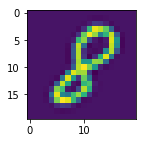

8


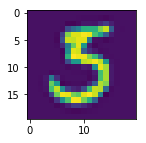

5


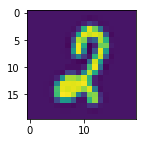

2


In [445]:
for n in np.random.randint(0, 5000, 3):
    display(X[n])
    print(y[n])

In [446]:
# Setup the parameters you will use for this part of the exercise
input_layer_size  = 400;  # 20x20 Input Images of Digits
num_labels = 10;          # 10 labels, from 1 to 10
                          # (note that we have mapped "0" to label 10)
m = X.shape[0]
n = X.shape[1] + 1

We write out our prediction function for our Neural Network we will train which is the same as we used in exercise 3.

In [447]:
def sigmoid(z):
    """
    calcuates sigmoid function 1/(1+e^-(z))
    """
    return 1/(1 + np.exp(-z))


def predict(Theta1, Theta2, X):
    """
    Perform forward-propogation to calculate the hypothesis 
    of the neural network for the 10 output layer nodes
    and select the largest valued node as the predicted 
    target variable (i.e. predicted label - the number in the image).
    """
    X = np.insert(X, 0, 1, 1) # insert column of ones 

    z2 = np.matmul(Theta1, X.transpose())  # calculate product of weights matrix with input layer
    a2 = sigmoid(z2); # calculate activation fn of 2nd layer (hidden layer)

    # Add ones to the a2 node activation matrix
    a2 = np.insert(a2, 0, 1, 0)

    z3 = np.matmul(Theta2, a2) # calculate product of weights matrix with 1st hidden layer
    h = sigmoid(z3); # calculate hypothesis fn of output layer
    
    prediction = np.argmax(h, axis=0) + 1 # get index of maximum element for each array of probability predictions for each classifier applied to each dataset (+1 to translate indexing to prediction)

    return prediction

Now we will write a function to compute the cost function for our parameters/weights $\Theta$, which are unrolled into a 1D vector.

In [448]:
def cost_function(Theta_vec, args):
    """
    Calculates the value of the cost function J
    """
    X, y, lamda, input_layer_size, hidden_layer_size, num_labels = args
    m = X.shape[0]
    
    # perform one-va-all encoding - map y to matrix of size num_labels*m
    y_oh = np.zeros([num_labels, m])
    for k in range(0, num_labels):
        y_oh[k, :] = y==(k+1)

    # --- First is reshaping the theta vector back to the 2 matricies --- 

    # Theta1 is weights multiplying the input layer (and bias term) to
    # give the hidden layer
    start = 0
    end = (input_layer_size+1)*hidden_layer_size
    Theta1 = np.reshape(
        Theta_vec[start:end],
        [hidden_layer_size, input_layer_size+1], order='F') 

    # Theta2 is weights multiplying the hidden layer (and bias term)
    # to give the output later (which has num_labels elements)
    start = end
    end = start + num_labels*(hidden_layer_size+1)
    Theta2 = np.reshape(
        Theta_vec[start:end],
        [num_labels, hidden_layer_size+1], order='F') 

    # ------

    X = np.insert(X, 0, 1, 1) # insert column of ones 

    z2 = np.matmul(Theta1, X.transpose())  # calculate product of weights matrix with input layer
    a2 = sigmoid(z2); # calculate activation fn of 2nd layer (hidden layer)

    # Add ones to the a2 node activation matrix
    a2 = np.insert(a2, 0, 1, 0)

    z3 = np.matmul(Theta2, a2) # calculate product of weights matrix with 1st hidden layer
    hypothesis = sigmoid(z3); # calculate hypothesis fn of output layer

    # calculate value of cost function 
    J = 1/m*np.sum(-y_oh*np.log(hypothesis) - (1-y_oh)*np.log(1-hypothesis))

    # add regularisation term (excepting bias weights)
    J += lamda*(np.sum(Theta1[:, 1:]**2) + np.sum(Theta2[:, 1:]**2))/(2*m)

    return J

In [449]:
# Defining Neural Network Size
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

We now test out cost function works correctly without regularisation ($\lambda = 0$) on a known set of weights (those we used for ex3)

In [450]:
Theta1 = scipy.io.loadmat('Theta1.mat')
Theta1 = Theta1['Theta1']
Theta2 = scipy.io.loadmat('Theta2.mat')
Theta2 = Theta2['Theta2']

def unroll(A, B):
    return np.concatenate((A.reshape(A.size, order='F'), B.reshape(B.size, order='F')))

Theta_vec = unroll(Theta1, Theta2)

In [451]:
lamda = 0
args = X, y, lamda, input_layer_size, hidden_layer_size, num_labels 
cost_function(Theta_vec, args)

0.28762916516131887

We expect the answer ~0.287629

In [452]:
lamda = 1
args = X, y, lamda, input_layer_size, hidden_layer_size, num_labels 
cost_function(Theta_vec, args)

0.38376985909092359

We expect the answer ~0.383770

In [453]:
def sigmoid_gradient(z):
    """
    calculates the gradient of the sigmoid function.
    """
    return sigmoid(z)*(1-sigmoid(z))

We now write a function to generate randomized initial weights to break the symmetry so that the optimal weights can be different.

In [454]:
def randomize_weights(input_layer_size, hidden_layer_size, num_labels, eps=0.12):
    """
    Generate randomized weights vector
    """
    total_size = hidden_layer_size*(input_layer_size+1) + num_labels*(hidden_layer_size+1)
    Theta_vec = np.random.uniform(low=-eps_init, high=+eps_init, size=total_size)
    return Theta_vec

Below we write the function that allows our network to learn - the backpropogation algorithm which solves for the gradient of the cost function.

In [468]:
def gradient(Theta_vec, args):
    """
    Calculates the gradient of the cost function.
    """
    X, y, lamda, input_layer_size, hidden_layer_size, num_labels = args
    m = X.shape[0]
    
    # perform one-va-all encoding - map y to matrix of size num_labels*m
    y_oh = np.zeros([num_labels, m])
    for k in range(0, num_labels):
        y_oh[k, :] = y==(k+1)

    # ---- First is reshaping the theta vector back to the 2 matricies

    # Theta1 is weights multiplying the input layer (and bias term) to
    # give the hidden layer
    start = 0
    end = (input_layer_size+1)*hidden_layer_size
    Theta1 = np.reshape(
        Theta_vec[start:end],
        [hidden_layer_size, input_layer_size+1], order='F') 

    # Theta2 is weights multiplying the hidden layer (and bias term)
    # to give the output later (which has num_labels elements)
    start = end
    end = start + num_labels*(hidden_layer_size+1)
    Theta2 = np.reshape(
        Theta_vec[start:end],
        [num_labels, hidden_layer_size+1], order='F') 

    # ----

    X = np.insert(X, 0, 1, 1) # insert column of ones 

    Delta2 = np.zeros_like(Theta2)
    Delta1 = np.zeros_like(Theta1)

    for i in range(0, m):
        x_i = X[i, :]
        y_i = y_oh[:, i]

        a1 = x_i

        # --- Forward Propogation step ---
        
        # calculate product of weights matrix with input layer
        z2 = np.matmul(Theta1, a1)  

        # calculate activation fn of 2nd layer (hidden layer)
        a2 = sigmoid(z2); 

        # Add ones to the a2 node activation matrix
        a2 = np.insert(a2, 0, 1, 0)

        # calculate product of weights matrix with 1st hidden layer
        z3 = np.matmul(Theta2, a2) 
        
        # calculate hypothesis fn of output layer
        hypothesis = sigmoid(z3);     
        # ------

        # --- Backpropogation step to calculate error in nodes output ---
        
        # error in output layer nodes
        delta3 = hypothesis-y_i # error in output layer


        # error in hidden layer nodes
        gprime_z2 = np.append([0], sigmoid_gradient(z2)) # add zero to front as gradient of the bias activation is 0 (it's always +1)
        delta2 = np.matmul(Theta2.transpose(), delta3)*gprime_z2
        # remove error in activation of bias node as bias can't be changed from +1
        delta2 = delta2[1:] 


        # acculuate total error in weights from this data point
        Delta2 += np.matmul(delta3[np.newaxis].transpose(), a2[np.newaxis])

        Delta1 += np.matmul(delta2[np.newaxis].transpose(), a1[np.newaxis])
        

        # ------

    Theta1_grad = Delta1/m # calculate gradient - dJ/d(Theta1)
    Theta2_grad = Delta2/m # calculate gradient - dJ/d(Theta2)

    # --- adding regularisation terms ---

    Theta1_zerobias = np.copy(Theta1)
    Theta1_zerobias[:, 0] = 0 # zeros weights multiplying bias a1_0
    Theta2_zerobias = np.copy(Theta2)
    Theta2_zerobias[:, 0] = 0 # zeros weights multiplying bias a2_0

    Theta1_grad += lamda/m*Theta1_zerobias
    Theta2_grad += lamda/m*Theta2_zerobias

    # ------

    # unroll gradient matricies into 1D vector
    gradient = unroll(Theta1_grad, Theta2_grad)
    
    return gradient

We now write a function to calculate the gradient numerically, using finite differencing, this is to check that our gradient of the cost function calculated with backpropogation is correct.

In [456]:
def calc_numerical_gradient(Theta_vec, args, eps=1e-4,):
    gradient = np.zeros_like(Theta_vec)
    for i, _ in enumerate(Theta_vec):
        Theta_vec_plus = np.copy(Theta_vec)
        Theta_vec_plus[i] += eps
        Theta_vec_minus = np.copy(Theta_vec)
        Theta_vec_minus[i] -= eps
        
        gradient[i] = (cost_function(Theta_vec_plus, args) - cost_function(Theta_vec_minus, args))/(2*eps)
    return gradient

We now calculate the gradient with backpropogation and finite differencing to check our implementation of backpropogation is correct.

In [469]:
input_layer_size_test = 3;
hidden_layer_size_test = 5;
num_labels_test = 3;
m_test = 5;

test_vals = scipy.io.loadmat('test_vals.mat')
Theta_vec_test = test_vals['nn_params'].flatten()

X_test = test_vals['X']
y_test = test_vals['y'].flatten()

First in the unregularised case:

In [470]:
lamda = 0
args = X_test, y_test, lamda, input_layer_size_test, hidden_layer_size_test, num_labels_test 

grad = gradient(Theta_vec_test, args)

grad_num = calc_numerical_gradient(Theta_vec_test, args)

# for i, gi in enumerate(grad):
#     print("numerical: {:.6f}  backprop: {:.6f}".format(grad_num[i], gi))

difference = np.sum(abs(grad-grad_num))
print(difference)

1.10219466607e-10


The difference here should be very small.

In [475]:
lamda = 1
args = X_test, y_test, lamda, input_layer_size_test, hidden_layer_size_test, num_labels_test 

grad = gradient(Theta_vec_test, args)

args = X_test, y_test, lamda, input_layer_size_test, hidden_layer_size_test, num_labels_test 

grad_num = calc_numerical_gradient(Theta_vec_test, args)

# for i, gi in enumerate(grad):
#     print("numerical: {:.6f}  backprop: {:.6f}".format(grad_num[i], gi))

difference = np.sum(abs(grad-grad_num))
print(difference)

1.21881466725e-10


The difference here should also be very small.

We can now train our Neural Network - i.e. minimize $J(\Theta)$ over the $\Theta$ parameters to find our optimal $\Theta$ parameters / weights for our Neural Network.

In [480]:
def callback(x):
    global iterNo
    iterNo += 1
    print('iteration: {}'.format(iterNo))

In [487]:
iterNo = 0

lamda = 1
args = [X, y, lamda, input_layer_size, hidden_layer_size, num_labels]

initial_Theta_vec = randomize_weights(input_layer_size, hidden_layer_size, num_labels)

result = scipy.optimize.minimize(cost_function, 
        x0=initial_Theta_vec, 
        jac=gradient,
        args=args,
        method="L-BFGS-B",
        options={'disp':True,
        'maxiter':50},
        callback=callback,
        )
Theta_vec_opt = result.x

iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51


In [488]:
start = 0
end = (input_layer_size+1)*hidden_layer_size
Theta1 = np.reshape(
    Theta_vec_opt[start:end],
    [hidden_layer_size, input_layer_size+1], order='F') 

# Theta2 is weights multiplying the hidden layer (and bias term)
# to give the output later (which has num_labels elements)
start = end
end = start + num_labels*(hidden_layer_size+1)
Theta2 = np.reshape(
    Theta_vec_opt[start:end],
    [num_labels, hidden_layer_size+1], order='F') 

In [489]:
pred_nn = predict(Theta1, Theta2, X)

In [490]:
accuracy = np.sum(pred_nn == y)/y.shape[0]
print("Accuracy = {:.1f}%".format(accuracy*100))

Accuracy = 97.3%
